In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#total ligne 423768
file_path = "C:/Users/PC HP 1/Desktop/2025-03-21/old_data/SAMPLE_CHURN (1).csv"
df = pd.read_csv(file_path)

# Preview the dataset
print("Dataset Overview:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

C:\Users\PC HP 1\AppData\Local\Temp\ipykernel_6620\4263745967.py:8: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Dataset Overview:
  churn classe_anciennete  subscriber_id                            msisdn  \
0    No               NaN            NaN                               NaN   
1    No     0 to 3 Months   2.180781e+09  dc77fad2110cc23f31bbe0166de8c377   
2    No     0 to 3 Months   2.180606e+09  9d13a3fcf7f20203914c49c32ca6a0ea   
3    No     0 to 3 Months   2.180584e+09  9b6c47edad2f25ffac743b6849b6bf26   
4    No     0 to 3 Months   2.180725e+09  a467b76595494a4b88f2a39fa99b9d15   

   sales_channel_description            date_activation churn_date  \
0                        NaN                        NaN        NaN   
1                        NaN  10JAN2025:00:00:00.000000        NaN   
2                        NaN  19FEB2025:16:50:18.000000        NaN   
3                        NaN  23DEC2024:00:00:00.000000        NaN   
4                        NaN  06JAN2025:00:00:00.000000        NaN   

             first_call_date             last_call_date  \
0                        NaN     

In [49]:
df = df.drop(columns=["sales_channel_description"])

In [ ]:
df = df.drop(columns=["dat_attrib_kridi"])

In [50]:
df = df.drop(columns=["ported_in_request_date"])

In [51]:
df = df.dropna(subset=["classe_anciennete"])

In [52]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
churn                                0
classe_anciennete                    0
subscriber_id                        0
msisdn                               0
date_activation                      0
churn_date                      312829
first_call_date                  25352
last_call_date                   25352
first_recharge_date              58199
first_recharge_amount            58199
last_international_call_date    418327
original_operator                    0
dat_attrib_kridi                423764
dat_remb_kridi_net              278343
SelectionProb                        0
SamplingWeight                       0
dtype: int64


In [53]:
missing_churn_date = df[(df["churn"] == "Yes") & (df["churn_date"].isnull())]
print("Invalid rows (churn = Yes but churn_date is missing)", len(missing_churn_date))

Invalid rows (churn = Yes but churn_date is missing) 0


In [54]:
invalid_churn_date = df[(df["churn"] == "No") & (df["churn_date"].notnull())]
print("Invalid rows (churn = No but churn_date is filled):", len(invalid_churn_date))

Invalid rows (churn = No but churn_date is filled): 74681


In [55]:
df.loc[df["churn"] == "No", "churn_date"] = pd.NaT

In [56]:
# Confirm that churn_date is null for all churn = "No"
print(df[df["churn"] == "No"]["churn_date"].isnull().all())  # Should return True

True


In [57]:
# Create binary flag: 1 if international call exists, 0 otherwise
df["has_international_call"] = df["last_international_call_date"].notnull().astype(int)
#df = df.drop(columns=["last_international_call_date"])

In [58]:
# Create binary column: 1 if kridi attrib OR kridi repayment exists
df["has_kridi"] = (
    df["dat_attrib_kridi"].notnull() | df["dat_remb_kridi_net"].notnull()
).astype(int)
#df = df.drop(columns=["dat_attrib_kridi", "dat_remb_kridi_net"])

In [59]:
# === Step 1: Binary column for call activity ===
df["has_called"] = df["first_call_date"].notnull().astype(int)

# === Step 2: Binary column for recharge activity ===
df["has_recharged"] = df["first_recharge_date"].notnull().astype(int)

# Optionally drop these if you only care about the flag:
#df.drop(["first_call_date", "last_call_date"], axis=1, inplace=True)

# Optionally drop these if you only care about the flag:
#df.drop(["first_recharge_date", "first_recharge_amount"], axis=1, inplace=True)

# === Optional: If you want to keep recharge amount for customers who recharged only ===
# You could fill missing values with 0 ONLY IF you add has_recharged flag
# df["first_recharge_amount"] = df["first_recharge_amount"].fillna(0)

In [60]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['churn'] = le.fit_transform(df['churn'])  # Yes/No → 1/0

In [61]:
# from sklearn.preprocessing import StandardScaler
# num_cols = [ 'SamplingWeight']  
# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

In [62]:
print(df['original_operator'].unique())
df['original_operator_binary'] = df['original_operator'].apply(lambda x: 1 if x == 'Ooredoo' else 0)

['Ooredoo' 'Non Ooredoo']


In [63]:
import pandas as pd
from datetime import datetime

# Make sure date columns are parsed correctly
date_cols = ['date_activation', 'churn_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format='%d%b%Y:%H:%M:%S.%f')

# Get today's date (you can replace this with the date of data extraction if needed)
today = pd.to_datetime('today')

# Create tenure_in_days:
df['tenure_in_days'] = (df['churn_date'].fillna(today) - df['date_activation']).dt.days

# Create days_since_activation (useful for active clients only)
df['days_since_activation'] = (today - df['date_activation']).dt.days

# Show the new columns
print(df[['date_activation', 'churn_date', 'tenure_in_days', 'days_since_activation']].head())

      date_activation churn_date  tenure_in_days  days_since_activation
1 2025-01-10 00:00:00        NaT             216                    216
2 2025-02-19 16:50:18        NaT             175                    175
3 2024-12-23 00:00:00        NaT             234                    234
4 2025-01-06 00:00:00        NaT             220                    220
5 2024-12-23 00:00:00        NaT             234                    234


In [64]:
# import pandas as pd
# from datetime import datetime

# # Make sure date columns are parsed correctly
# date_cols = ['date_activation', 'churn_date', 'last_call_date', 'first_recharge_date']
# for col in date_cols:
#     df[col] = pd.to_datetime(df[col], errors='coerce', format='%d%b%Y:%H:%M:%S.%f')

# # Get today's date (you can replace this with the date of data extraction if needed)
# today = pd.to_datetime('today')

# # Create tenure_in_days
# df['tenure_in_days'] = (df['churn_date'].fillna(today) - df['date_activation']).dt.days

# # Create days_since_activation (useful for active clients only)
# df['days_since_activation'] = (today - df['date_activation']).dt.days

# #  Create new columns
# df['days_inactive'] = (df['churn_date'] - df['last_call_date']).dt.days
# df['days_between_activation_and_first_recharge'] = (
#     df['first_recharge_date'] - df['date_activation']
# ).dt.days

# # Show sample of new columns
# print(df[['date_activation', 'churn_date', 'last_call_date', 'first_recharge_date',
#           'tenure_in_days', 'days_since_activation', 
#           'days_inactive', 'days_between_activation_and_first_recharge']].head())


In [65]:
df['churn'].value_counts(normalize=True)

churn
0    0.914443
1    0.085557
Name: proportion, dtype: float64

In [66]:
# Preview the dataset
print("Dataset Overview:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

Dataset Overview:
   churn classe_anciennete  subscriber_id                            msisdn  \
1      0     0 to 3 Months   2.180781e+09  dc77fad2110cc23f31bbe0166de8c377   
2      0     0 to 3 Months   2.180606e+09  9d13a3fcf7f20203914c49c32ca6a0ea   
3      0     0 to 3 Months   2.180584e+09  9b6c47edad2f25ffac743b6849b6bf26   
4      0     0 to 3 Months   2.180725e+09  a467b76595494a4b88f2a39fa99b9d15   
5      0     0 to 3 Months   2.180582e+09  931925bcd539b754a0fa5201e4e027a6   

      date_activation churn_date            first_call_date  \
1 2025-01-10 00:00:00        NaT                        NaN   
2 2025-02-19 16:50:18        NaT  30DEC2024:21:31:38.000000   
3 2024-12-23 00:00:00        NaT  23DEC2024:15:48:43.000000   
4 2025-01-06 00:00:00        NaT  07JAN2025:14:23:49.000000   
5 2024-12-23 00:00:00        NaT  23DEC2024:17:26:51.000000   

              last_call_date        first_recharge_date  \
1                        NaN  10JAN2025:11:31:57.000000   
2  19MAR20

In [67]:
# df[~df['classe_anciennete'].isin(anciennete_mapping.keys())]['classe_anciennete'].value_counts()

In [68]:
anciennete_mapping = {
    '0 to 3 Months': 0,
    '3 to 6 Months': 1,
    '6 to 12 Months': 2,
    '12 to 36 Months': 3,
    'More than 36 Months': 4
}
df['anciennete_encoded'] = df['classe_anciennete'].map(anciennete_mapping)

# df.drop('classe_anciennete', axis=1, inplace=True)

In [69]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
churn                                0
classe_anciennete                    0
subscriber_id                        0
msisdn                               0
date_activation                      0
churn_date                      387510
first_call_date                  25352
last_call_date                   25352
first_recharge_date              58199
first_recharge_amount            58199
last_international_call_date    418327
original_operator                    0
dat_attrib_kridi                423764
dat_remb_kridi_net              278343
SelectionProb                        0
SamplingWeight                       0
has_international_call               0
has_kridi                            0
has_called                           0
has_recharged                        0
original_operator_binary             0
tenure_in_days                       0
days_since_activation                0
anciennete_encoded                   0
dtype: int64


In [70]:
df['churn'].value_counts()

churn
0    387510
1     36256
Name: count, dtype: int64

Column: tenure_in_days — Outliers detected: 27795
Column: days_since_activation — Outliers detected: 28214


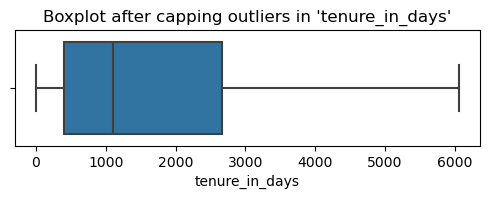

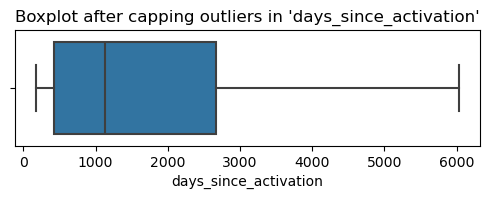

In [71]:
# === Step 1: Define the numeric columns to check for outliers ===
numeric_cols = ['tenure_in_days', 'days_since_activation']

# === Step 2: Function to detect and cap outliers ===
for col in numeric_cols:
    # Compute Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f"Column: {col} — Outliers detected: {outliers_count}")

    # Optional: Cap the outliers (Winsorization)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# === Step 3: Optional — Plot boxplots to visualize cleaned data ===
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot after capping outliers in '{col}'")
    plt.show()

In [72]:
#save after changes 
df.to_csv('cleaned_churn_data.csv', index=False)

In [73]:
import os
print(os.getcwd())

C:\Users\PC HP 1


In [74]:
print(df.head())

   churn classe_anciennete  subscriber_id                            msisdn  \
1      0     0 to 3 Months   2.180781e+09  dc77fad2110cc23f31bbe0166de8c377   
2      0     0 to 3 Months   2.180606e+09  9d13a3fcf7f20203914c49c32ca6a0ea   
3      0     0 to 3 Months   2.180584e+09  9b6c47edad2f25ffac743b6849b6bf26   
4      0     0 to 3 Months   2.180725e+09  a467b76595494a4b88f2a39fa99b9d15   
5      0     0 to 3 Months   2.180582e+09  931925bcd539b754a0fa5201e4e027a6   

      date_activation churn_date            first_call_date  \
1 2025-01-10 00:00:00        NaT                        NaN   
2 2025-02-19 16:50:18        NaT  30DEC2024:21:31:38.000000   
3 2024-12-23 00:00:00        NaT  23DEC2024:15:48:43.000000   
4 2025-01-06 00:00:00        NaT  07JAN2025:14:23:49.000000   
5 2024-12-23 00:00:00        NaT  23DEC2024:17:26:51.000000   

              last_call_date        first_recharge_date  \
1                        NaN  10JAN2025:11:31:57.000000   
2  19MAR2025:20:51:21.000000